In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
from utils import getConstructorColours
from api import JolpicaF1API

In [2]:
api = JolpicaF1API()
constructorColors = getConstructorColours()

In [3]:
season_info = api.getDriverStandings(2024)
try:
    # Get the last round number from the response
    last_round = int(season_info['MRData']['StandingsTable']['StandingsLists'][0]['round'])
    print(f"Found {last_round} rounds in the 2024 season so far")
except (KeyError, IndexError):
    last_round = 10
    print(f"Could not determine the number of rounds, using default of {last_round}")

Found 24 rounds in the 2024 season so far


In [4]:
def extract_driver_standings(data):
    standings_list = data['MRData']['StandingsTable']['StandingsLists'][0]
    race_name = standings_list.get('round', 'Unknown')
    
    driver_standings = []
    for driver in standings_list['DriverStandings']:
        driver_info = {
            'position': int(driver['position']),
            'points': float(driver['points']),
            'code': driver['Driver']['code'],
            'driverId': driver['Driver']['driverId'],
            'givenName': driver['Driver']['givenName'],
            'familyName': driver['Driver']['familyName'],
            'team_name': driver['Constructors'][0]['name'],
            'round': int(race_name) if race_name != 'Unknown' else 0
        }
        driver_standings.append(driver_info)
    
    return pd.DataFrame(driver_standings)

In [5]:
def extract_constructor_standings(data):
    standings_list = data['MRData']['StandingsTable']['StandingsLists'][0]
    race_name = standings_list.get('round', 'Unknown')
    
    constructor_standings = []
    for constructor in standings_list['ConstructorStandings']:
        constructor_info = {
            'position': int(constructor['position']),
            'points': float(constructor['points']),
            'name': constructor['Constructor']['name'],
            'constructorId': constructor['Constructor']['constructorId'],
            'round': int(race_name) if race_name != 'Unknown' else 0
        }
        constructor_standings.append(constructor_info)
    
    return pd.DataFrame(constructor_standings)

In [6]:
race_names = {}

print("Collecting race names for each round...")
for round_num in range(1, last_round + 1):
    print(f"Fetching race info for round {round_num}...")
    race_data = api.getRaceInfo(2024, round_num)
    
    try:
        race_name = race_data['MRData']['RaceTable']['Races'][0]['raceName']
        race_names[round_num] = race_name
    except (KeyError, IndexError):
        race_names[round_num] = f"Round {round_num}"
    
    time.sleep(0.5)

Fetching race info for round 1...
Fetching race info for round 2...
Fetching race info for round 3...
Fetching race info for round 4...
Fetching race info for round 5...
Fetching race info for round 6...
Fetching race info for round 7...
Fetching race info for round 8...
Fetching race info for round 9...
Fetching race info for round 10...
Fetching race info for round 11...
Fetching race info for round 12...
Fetching race info for round 13...
Fetching race info for round 14...
Fetching race info for round 15...
Fetching race info for round 16...
Fetching race info for round 17...
Fetching race info for round 18...
Fetching race info for round 19...
Fetching race info for round 20...
Fetching race info for round 21...
Fetching race info for round 22...
Fetching race info for round 23...
Fetching race info for round 24...


In [7]:
all_driver_standings = []

print("Collecting driver standings for each round...")
for round_num in range(1, last_round + 1):
    print(f"Fetching data for round {round_num}...")
    driver_data = api.getDriverStandings(2024, round_num)
    
    round_standings = extract_driver_standings(driver_data)
    all_driver_standings.append(round_standings)
    
    time.sleep(0.5)

Fetching data for round 1...
Fetching data for round 2...
Fetching data for round 3...
Fetching data for round 4...
Fetching data for round 5...
Fetching data for round 6...
Fetching data for round 7...
Fetching data for round 8...
Fetching data for round 9...
Fetching data for round 10...
Fetching data for round 11...
Fetching data for round 12...
Fetching data for round 13...
Fetching data for round 14...
Fetching data for round 15...
Fetching data for round 16...
Fetching data for round 17...
Fetching data for round 18...
Fetching data for round 19...
Fetching data for round 20...
Fetching data for round 21...
Fetching data for round 22...
Fetching data for round 23...
Fetching data for round 24...


In [8]:
driver_performance_2024 = pd.concat(all_driver_standings, ignore_index=True)
driver_performance_2024['race_name'] = driver_performance_2024['round'].map(race_names)

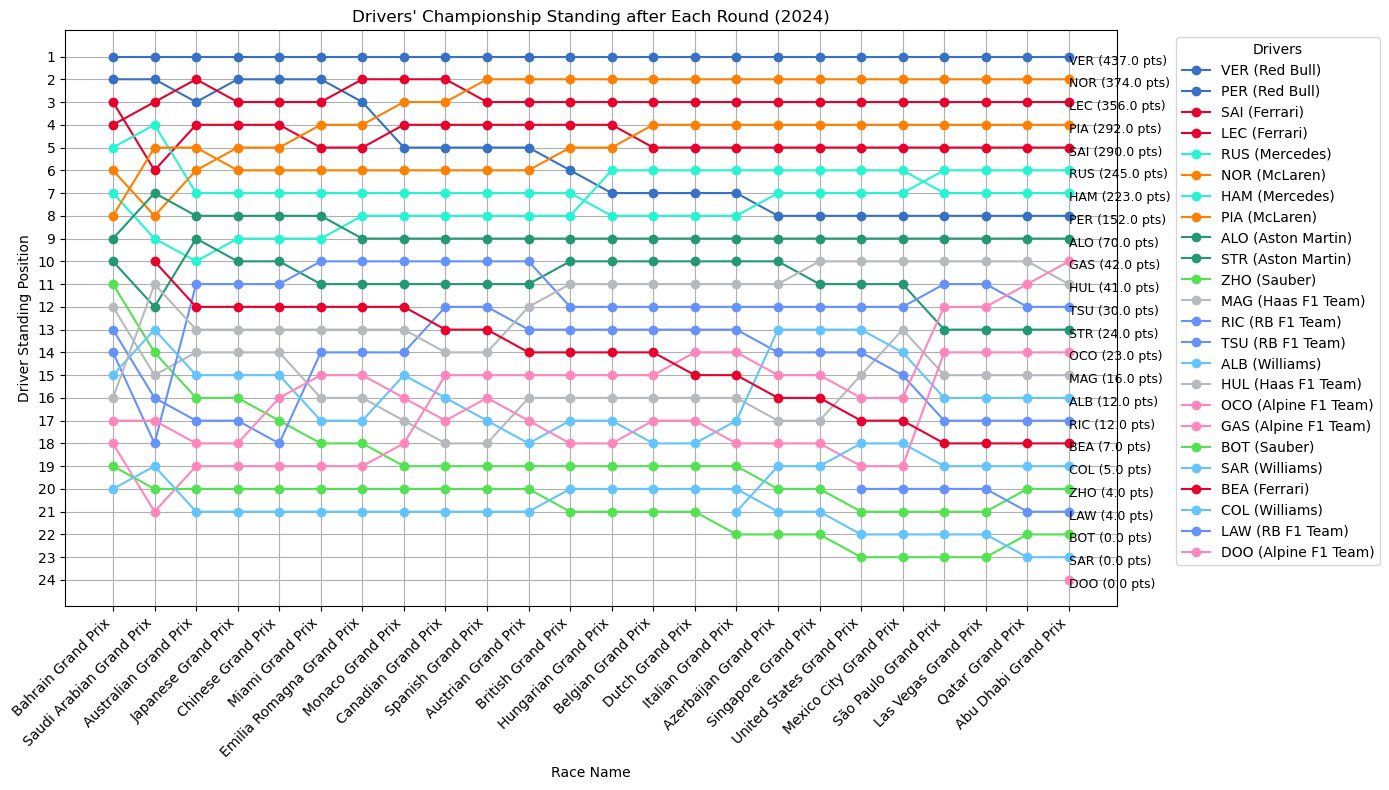

In [9]:
plt.figure(figsize=(14, 8))

# Loop through each driver code to plot their standings over rounds
for code in driver_performance_2024['code'].unique():
    driver_data = driver_performance_2024[driver_performance_2024['code'] == code].sort_values('round')
    team = driver_data['team_name'].iloc[0]

    plt.plot(driver_data['race_name'], driver_data['position'], marker='o',
             label=f'{code} ({team})', color=constructorColors.get(team, '#000000'), linestyle='-')

    # Adding labels to the last point only
    last_row = driver_data.iloc[-1]
    plt.text(
        x=last_row['race_name'], 
        y=last_row['position'] + 0.2,  # Offset label slightly
        s=f'{last_row["code"]} ({last_row["points"]} pts)', 
        fontsize=9, 
        ha='left', 
        va='center', 
        color='black'
    )

# Invert y-axis so 1st position is at the top
plt.gca().invert_yaxis()

# Set y-axis ticks to be every integer value
max_position = driver_performance_2024['position'].max()
plt.yticks(range(1, max_position + 1))

plt.xlabel('Race Name')
plt.ylabel('Driver Standing Position')
plt.title('Drivers\' Championship Standing after Each Round (2024)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Drivers', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
all_constructor_standings = []

print("Collecting constructor standings for each round...")
for round_num in range(1, last_round + 1):
    print(f"Fetching constructor data for round {round_num}...")
    constructor_data = api.getConstructorStandings(2024, round_num)
    round_standings = extract_constructor_standings(constructor_data)
    all_constructor_standings.append(round_standings)

    time.sleep(0.5)

Fetching constructor data for round 1...
Fetching constructor data for round 2...
Fetching constructor data for round 3...
Fetching constructor data for round 4...
Fetching constructor data for round 5...
Fetching constructor data for round 6...
Fetching constructor data for round 7...
Fetching constructor data for round 8...
Fetching constructor data for round 9...
Fetching constructor data for round 10...
Fetching constructor data for round 11...
Fetching constructor data for round 12...
Fetching constructor data for round 13...
Fetching constructor data for round 14...
Fetching constructor data for round 15...
Fetching constructor data for round 16...
Fetching constructor data for round 17...
Fetching constructor data for round 18...
Fetching constructor data for round 19...
Fetching constructor data for round 20...
Fetching constructor data for round 21...
Fetching constructor data for round 22...
Fetching constructor data for round 23...
Fetching constructor data for round 24...


In [11]:
constructor_performance_2024 = pd.concat(all_constructor_standings, ignore_index=True)
constructor_performance_2024['race_name'] = constructor_performance_2024['round'].map(race_names)

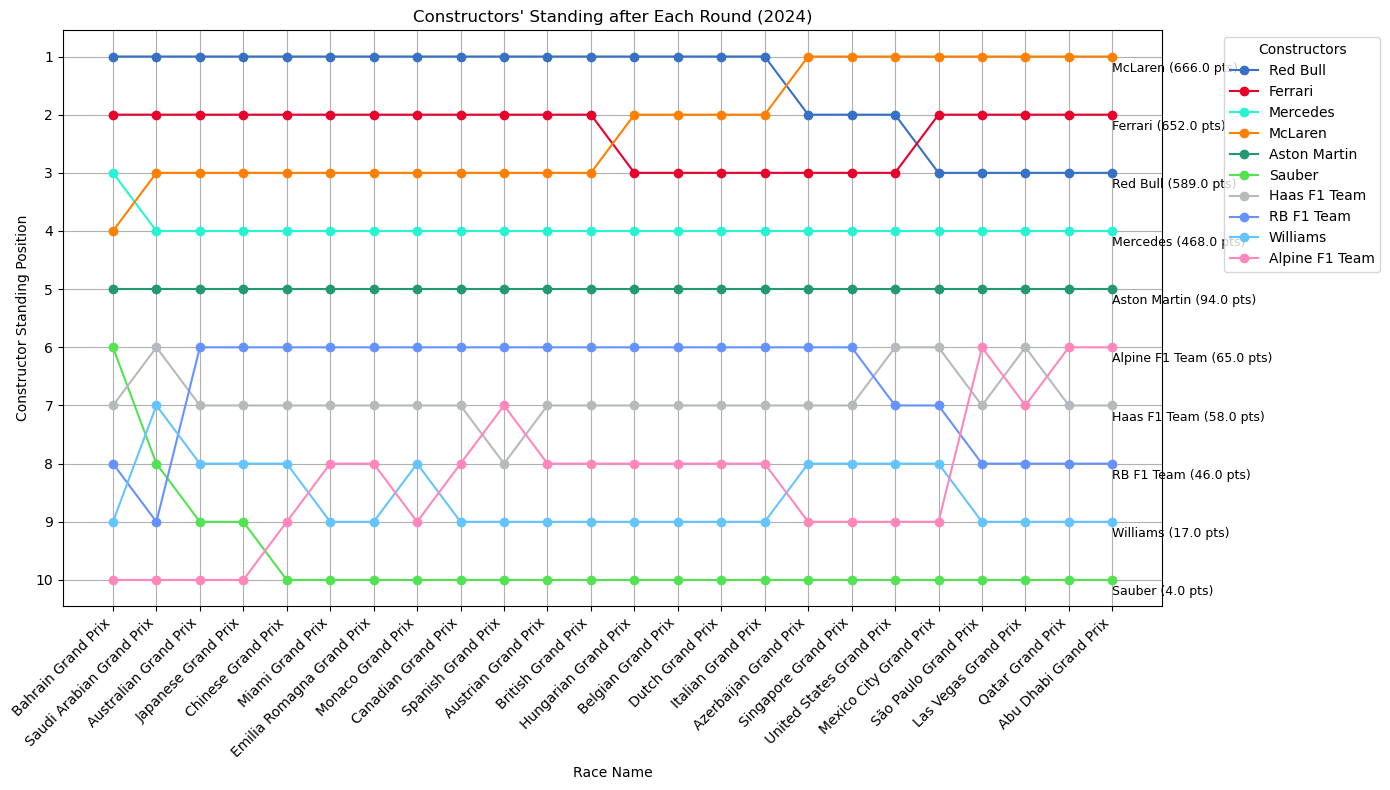

In [12]:
plt.figure(figsize=(14, 8))

# Loop through each constructor name to plot their standings over rounds
for name in constructor_performance_2024['name'].unique():
    constructor_data = constructor_performance_2024[constructor_performance_2024['name'] == name].sort_values('round')

        
    plt.plot(constructor_data['race_name'], constructor_data['position'], marker='o',
             label=f'{name}', color=constructorColors.get(name, '#000000'), linestyle='-')
    
    # Adding labels to the last point only
    last_row = constructor_data.iloc[-1]
    plt.text(
        x=last_row['race_name'], 
        y=last_row['position'] + 0.2,  # Offset label slightly
        s=f'{last_row["name"]} ({last_row["points"]} pts)', 
        fontsize=9, 
        ha='left', 
        va='center', 
        color='black'
    )

# Invert y-axis so 1st position is at the top
plt.gca().invert_yaxis()

# Set y-axis ticks to be every integer value
max_position = constructor_performance_2024['position'].max()
plt.yticks(range(1, max_position + 1))

plt.xlabel('Race Name')
plt.ylabel('Constructor Standing Position')
plt.title('Constructors\' Standing after Each Round (2024)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Constructors', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside plot
plt.grid(True)
plt.tight_layout()
plt.show()